In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from annotation_utilities import *
from registration_utilities import *
from conversion import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
stack = 'MD585'

In [68]:
contour_df = DataManager.load_annotation_v4(stack=stack, by_human=True, timestamp='latest', suffix='contours')
contour_df = convert_annotation_v3_original_to_aligned(contour_df, stack=stack)
# contour_df vertices wrt to aligned uncropped lossless image

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD585" "/shared/CSHL_labelings_v3/MD585" --exclude "*" --include "*contours*"
latest timestamp:  07192017045756


In [69]:
# Treat section as a single z value or a whole voxel slice.

In [70]:
downscale = 32

In [71]:
def contours_2d_to_3d(matched_contours, convert_to='aligned'):
    """
    Convert matched annotation dataframe entries to contours as a list of 3d array.
    """
    
    contours_3d = []
    
    for cnt_id, cnt in matched_contours.iterrows():

        fn = cnt['filename']
        if is_invalid(fn=fn, stack=stack) or not isinstance(fn, str): # Sometimes fn is nan, don't know why.
            continue
        
        section = metadata_cache['filenames_to_sections'][stack][fn]
        zl, zh = DataManager.convert_section_to_z(stack=stack, sec=section, downsample=downscale, z_begin=0, first_sec=1)
        z = int(np.round((zl + zh)/2))
        n = len(cnt['vertices'])
        vertices_on_aligned_3d = np.c_[cnt['vertices']/downscale, z*np.ones((n,))]
        contours_3d.append(vertices_on_aligned_3d)
        
    return contours_3d

In [72]:
contours_grouped_by_name = {}

for name_u in singular_structures:
#     print name_u
    
    matched_contours = contour_df[(contour_df['name'] == name_u)]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[name_u] = contours_3d

for name_u in paired_structures:
#     print name_u

    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'L')]
    if len(matched_contours) == 0:
        continue
    
    sections = list(matched_contours['section'])
    if len(sections) > 0:
        print convert_to_left_name(name_u), np.min(sections), np.max(sections), np.max(sections)-np.min(sections)+1
        print sorted(sections)
        
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_left_name(name_u)] = contours_3d
    
    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'R')]
    if len(matched_contours) == 0:
        continue
        
    sections = list(matched_contours['section'])
    if len(sections) > 0:
        print convert_to_right_name(name_u), np.min(sections), np.max(sections), np.max(sections)-np.min(sections)+1
        print sorted(sections)
        
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_right_name(name_u)] = contours_3d
    
    print 

5N_L 136 158 23
[136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
5N_R 271 294 24
[271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294]

6N_L 186 197 12
[186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
6N_R 222 230 9
[222, 223, 224, 225, 226, 227, 228, 229, 230]

7N_L 140 182 43
[140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
7N_R 252 294 43
[252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294]

7n_L 134 189 56
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,

In [73]:
structure_to_label = {structure: i + 1 for i, structure in enumerate(sorted(contours_grouped_by_name.keys()))}
contours_grouped_by_label = {structure_to_label[name]: contours 
                             for name, contours in contours_grouped_by_name.iteritems()}

In [74]:
volume, bbox = contours_to_volume(contours_grouped_by_label=contours_grouped_by_label, 
                                  interpolation_direction='z', return_shell=False)
print bbox
# bbox with wrt aligned uncropped specimen space.

(594, 1028, 125, 485, 113, 476)


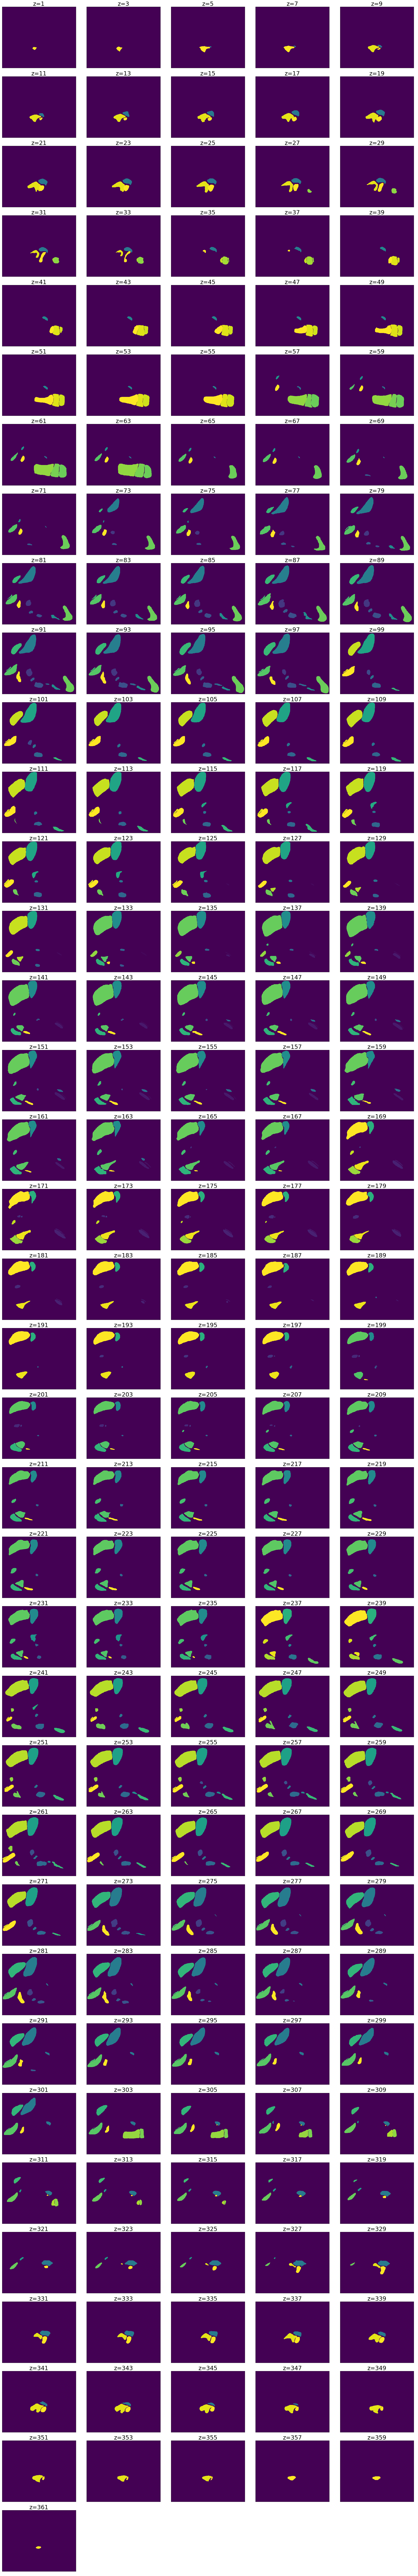

In [75]:
display_volume_sections(volume, every=2)

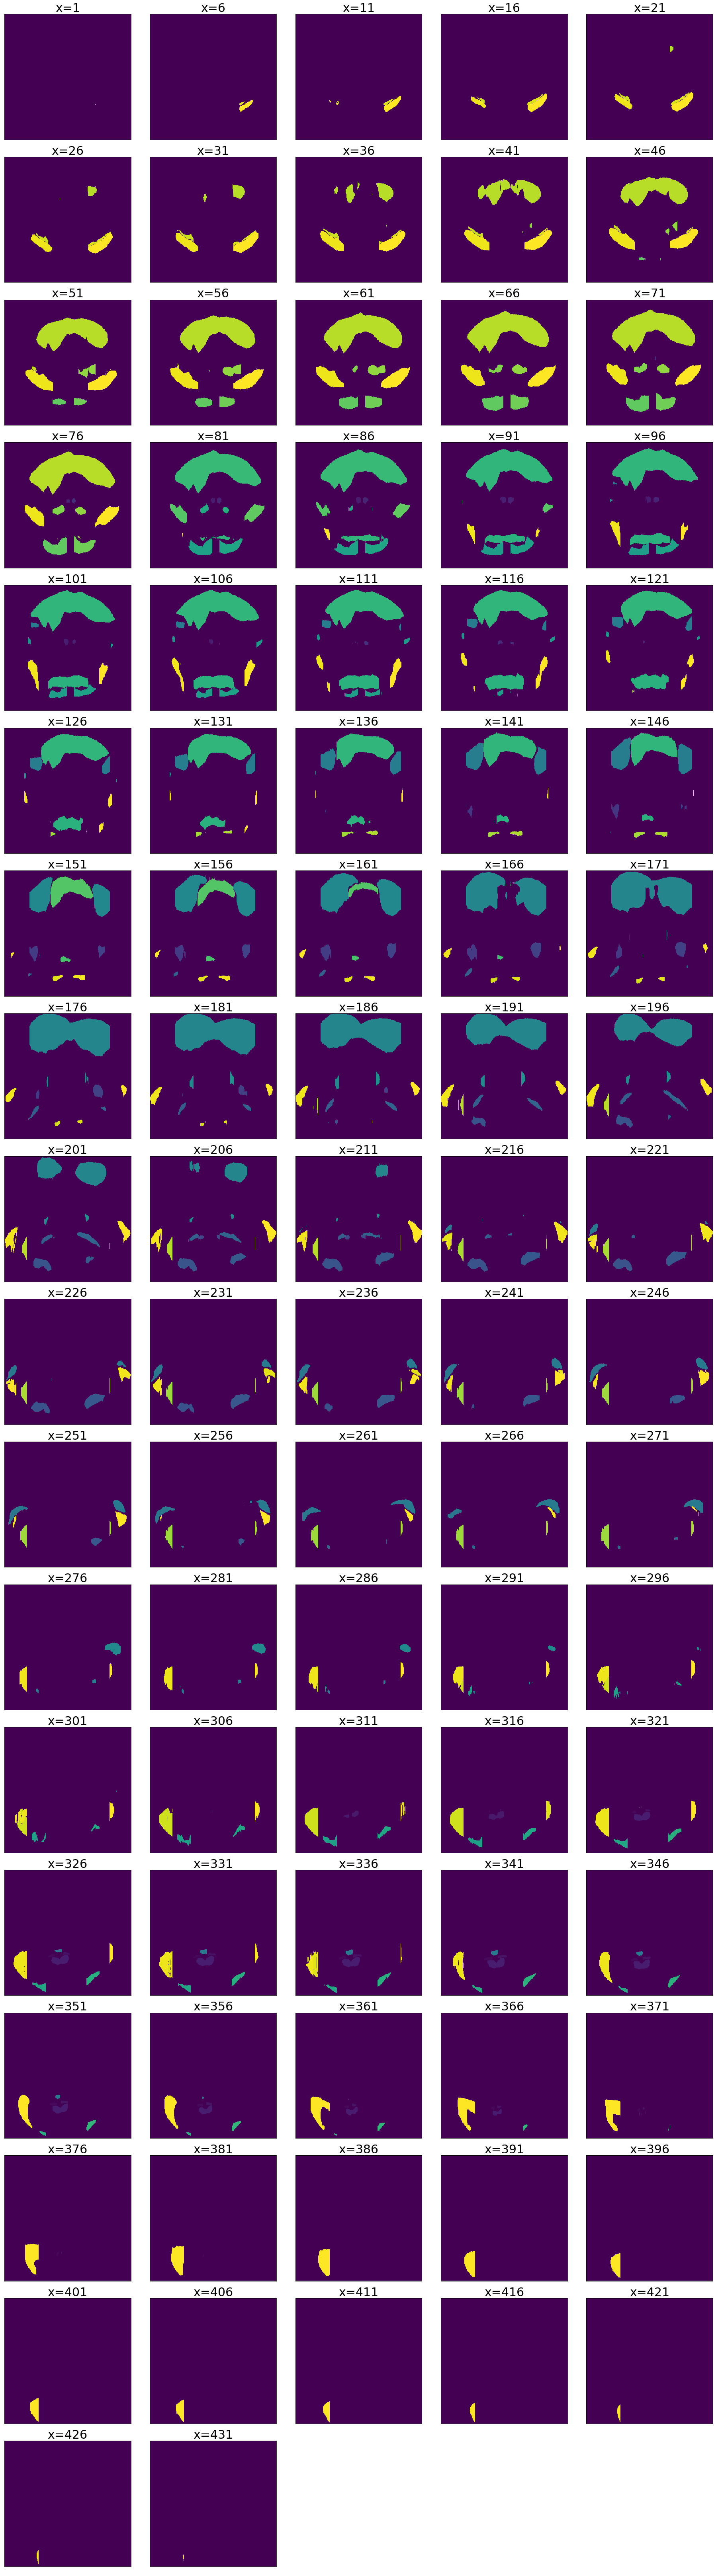

In [76]:
display_volume_sections(volume, every=5, direction='x')

# Output


In [77]:
vol_fp = DataManager.get_annotation_volume_filepath(stack=stack, downscale=downscale)
create_parent_dir_if_not_exists(vol_fp)
bp.pack_ndarray_file(volume, vol_fp)
upload_to_s3(vol_fp)

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume.bp"


In [78]:
bbox_fp = DataManager.get_annotation_volume_bbox_filepath(stack=stack, downscale=downscale)
np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
upload_to_s3(bbox_fp)

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume_bbox.txt"


In [79]:
name_label_map_fp = DataManager.get_volume_label_to_name_filepath(stack=stack)

with open(name_label_map_fp, 'w') as f:
    for structure, label in sorted(structure_to_label.items()):
        f.write(structure + ' ' + str(label) + '\n')
        
upload_to_s3(name_label_map_fp)

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume_nameToLabel.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationVolume/MD585_down32_annotationVolume_nameToLabel.txt"


In [34]:
# with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_landmarkBboxes.txt' % \
#                        dict(down=downsample_factor, stack=stack)), 'w') as f:
#     for name_s, label in sorted(name_s_to_label.items()):
#         bbox = bbox_3d(volume == label)
#         f.write(name_s + ' ' + ' '.join(map(str, bbox)) + '\n')

# Decompose as different volumes

In [80]:
volume = DataManager.load_annotation_volume(stack=stack, downscale=32)

print volume.shape

label_to_structure, structure_to_label = DataManager.load_volume_label_to_name(stack=stack)

# vol_xmin, vol_xmax, vol_ymin, vol_ymax, vol_zmin, vol_zmax = \
# DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation', downscale=32)

volume_decomposed = annotation_volume_to_score_volume(volume, label_to_structure)

(361, 435, 364)


In [81]:
bbox = DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation')

In [82]:
for structure, v in volume_decomposed.iteritems():
    fp = DataManager.get_original_volume_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(v, fp)
    upload_to_s3(fp)
    
    bbox_fp = DataManager.get_original_volume_bbox_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
    upload_to_s3(bbox_fp)

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_LRt_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_LRt_R.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_LRt_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_LRt_R_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5C_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5C_L.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5C_L_bbox.txt" "s3

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_12N_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_12N_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_SNR_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_SNR_R.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_SNR_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_SNR_R_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5O_L.bp" "s3

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5I_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5I_R.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_3N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_3N_R.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_3N_R_bbox.txt" "s3:/

aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_7n_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_7n_L_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_4N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_4N_L.bp"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_4N_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_4N_L_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_LC_L.bp" "s3://m

# Read

In [4]:
volume = DataManager.load_annotation_volume(stack='MD585', downscale=32)

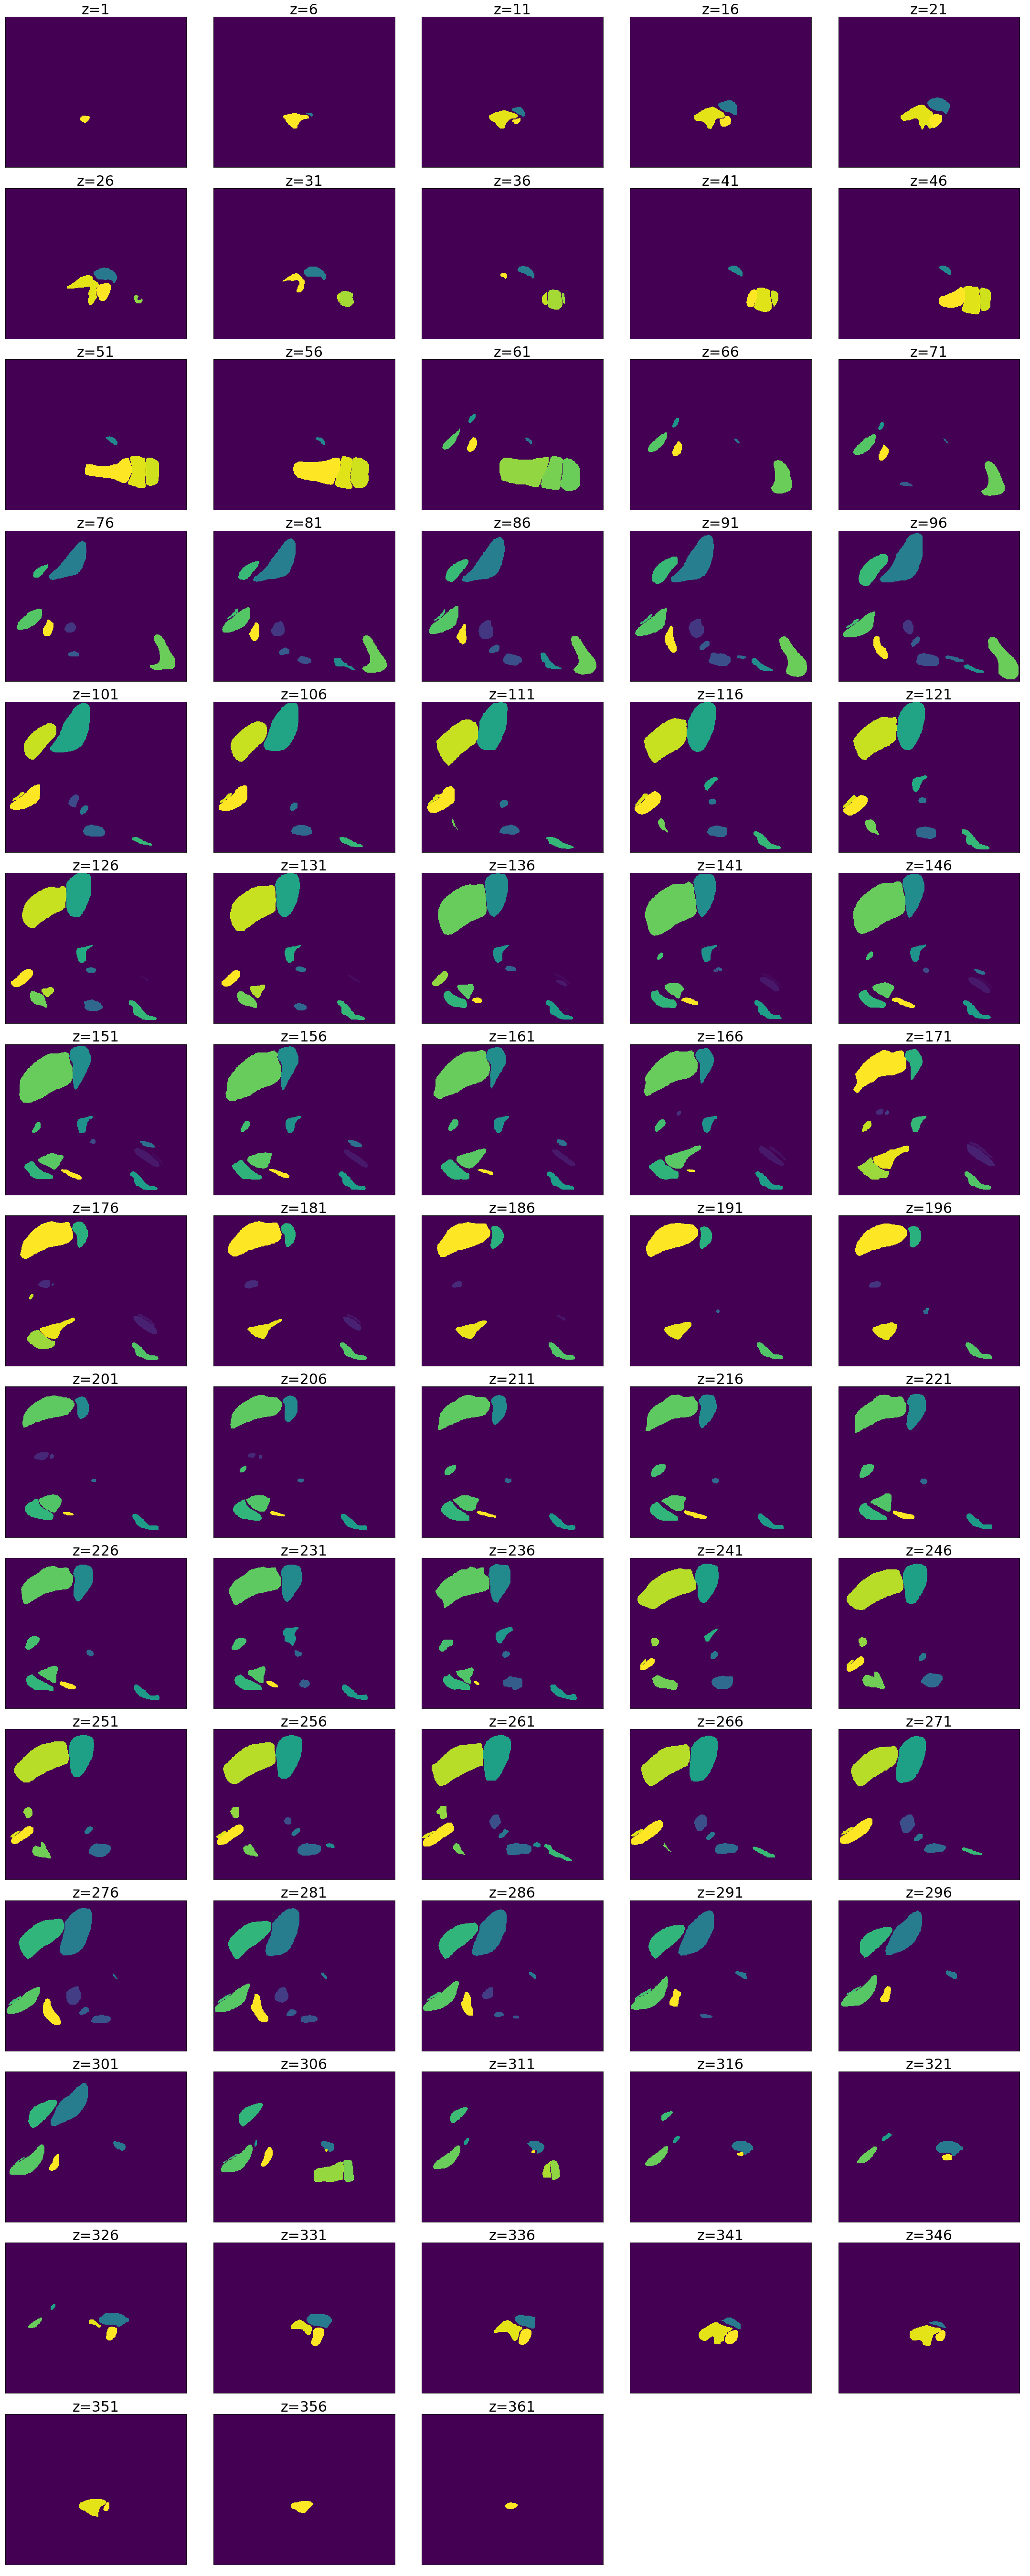

In [5]:
display_volume_sections(vol=volume)